In [1]:
import pandas as pd

data = pd.read_csv("data/police.csv")

### Part 4: Decision tree (From Week 4)

**The idea for this exercise is to pick two crime-types that have different geographical patterns and different temporal patterns. We can then use various variables of the real crime data as categories to build a decision tree. I'm thinking we can use**

- **`DayOfWeek` (`Sunday`, ..., `Saturday`). (Note: Will need to be encodede as integer in sklearn)**
- **`PD District` (`TENDERLOIN`, etc). (Note: Will need to be encodede as integer in sklearn)**

**And we can extract a few more from the `Time` and `Date` variables**

- **Hour of the day (1-24)**
- **Month of the year (1-12)**

**So your job is to *select two crime categories* that (based on your analyses from the past three weeks) have different spatio-temporal patterns.**

**Some notes/hints**

- **It is important for your success here to create a balanced dataset, that is, *grab an equal number of examples* from each of the two crime categories. Pick categories with lots of training data. It's probably nice to have something like 10000+ examples of each category to train on.**
- **Also, I recommend you grab your training data at random from the set of all examples, since we want crimes to be distributed equally over time.**

In [12]:
districts = data["PdDistrict"].unique()[:10]
categories = data.groupby(["Category"]).size().sort_values(ascending=False).head(8)
categories

Category
LARCENY/THEFT     480448
OTHER OFFENSES    309358
NON-CRIMINAL      238323
ASSAULT           194694
VEHICLE THEFT     126602
DRUG/NARCOTIC     119628
VANDALISM         116059
WARRANTS          101379
dtype: int64

The categories satisfying the 10.000+ condition are shown above. Extra integer columns are added for `Day`, `Dst` (district category), `Hour` and `Month`.

In [14]:
data.DayOfWeek = pd.Categorical(data.DayOfWeek)
data["Day"] = data.DayOfWeek.cat.codes
data.PdDistrict = pd.Categorical(data.PdDistrict)
data["Dst"] = data.PdDistrict.cat.codes
data["Hour"] = data.Time.map(lambda x: int(x[:2]))
data["Month"] = data.Date.map(lambda x: int(x[:2]))

To find out which two categories would suit the task well, we'll plot crime count against districts and different weekdays.

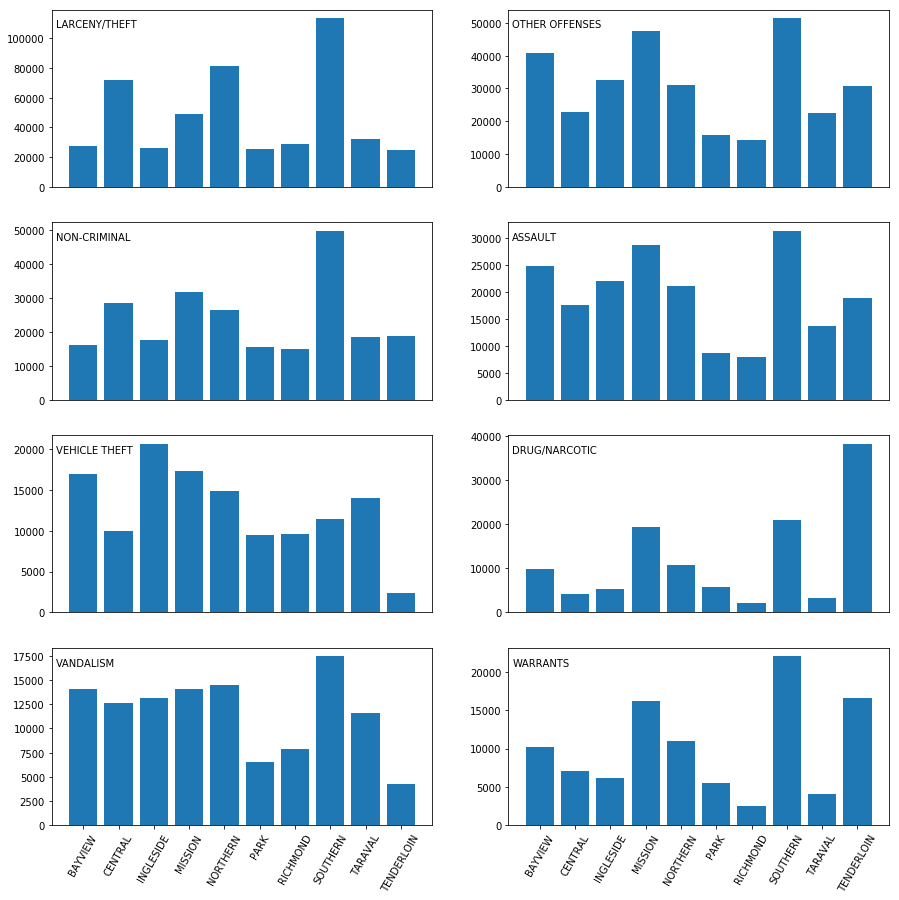

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(15, 15))
pos = np.arange(len(districts))

for i, category in enumerate(categories.keys()):
    ax = plt.subplot(4, 2, i + 1)
    ax.text(.01, .9, category, transform=ax.transAxes)
    
    displayed = data[data["Category"] == category].groupby(["PdDistrict"]).size()
    plt.bar(pos, displayed, align='center')
    
    if (i is 6) or (i is 7):
        plt.xticks(pos, displayed.keys(), rotation=60)
    else:
        plt.xticks([])

plt.show()

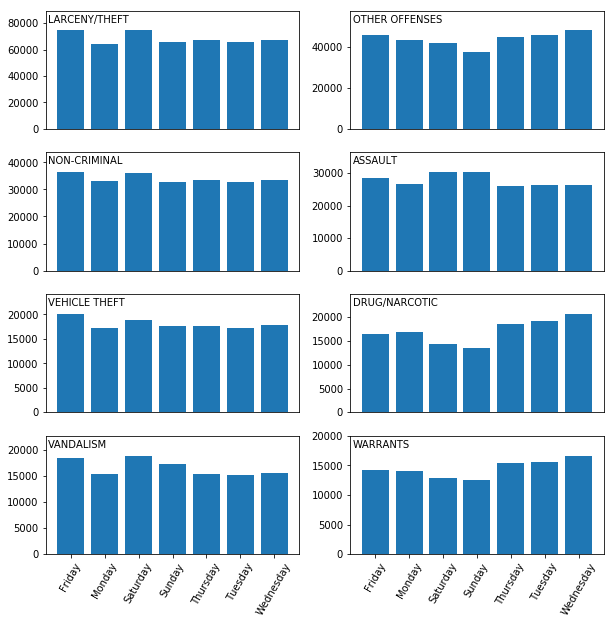

In [114]:
fig = plt.figure(figsize=(10, 10))
pos = np.arange(7)

for i, category in enumerate(categories.keys()):
    ax = plt.subplot(4, 2, i + 1)
    ax.text(.01, .9, category, transform=ax.transAxes)
    ax.margins(y=0.2)
    
    displayed = data[data["Category"] == category].groupby(["DayOfWeek"]).size()
    plt.bar(pos, displayed, align='center')
    
    if (i is 6) or (i is 7):
        plt.xticks(pos, displayed.keys(), rotation=60)
    else:
        plt.xticks([])

plt.show()

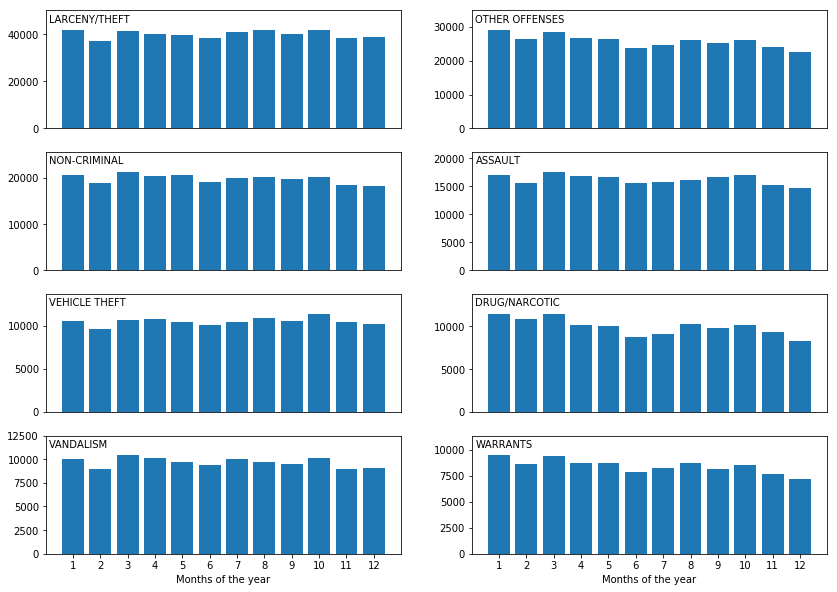

In [115]:
fig = plt.figure(figsize=(14, 10))
pos = np.arange(12)

for i, category in enumerate(categories.keys()):
    ax = plt.subplot(4, 2, i + 1)
    ax.text(.01, .9, category, transform=ax.transAxes)
    ax.margins(y=0.2)
    
    displayed = data[data["Category"] == category].groupby(["Month"]).size()
    plt.bar(pos, displayed, align='center')
    
    if (i is 6) or (i is 7):
        plt.xticks(pos, displayed.keys())
        plt.xlabel('Months of the year')
    else:
        plt.xticks([])

plt.show()

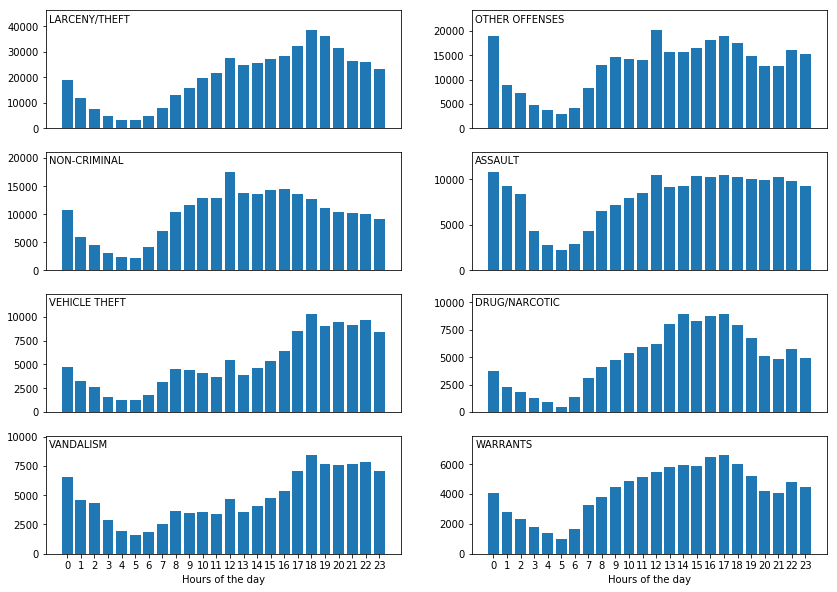

In [112]:
fig = plt.figure(figsize=(14, 10))
pos = np.arange(24)

for i, category in enumerate(categories.keys()):
    ax = plt.subplot(4, 2, i + 1)
    ax.text(.01, .9, category, transform=ax.transAxes)
    ax.margins(y=0.2)
    
    displayed = data[data["Category"] == category].groupby(["Hour"]).size()
    plt.bar(pos, displayed, align='center')
    
    if (i is 6) or (i is 7):
        plt.xticks(pos, displayed.keys())
        plt.xlabel('Hours of the day')
    else:
        plt.xticks([])

plt.show()

The differences between `VEHICLE THEFT` and `DRUG/NARCOTIC` look promising, thus we'll focus on those two. Then the dataset is cleaned by removing unnecessary columns and selecting the specific rows.

In [23]:
vehicle_data = data[data["Category"] == "VEHICLE THEFT"][["Dst", "Day", "Hour", "Month"]]
vehicle_clean = vehicle_data.sample(frac=1).reset_index(drop=True)
vehicle_train = vehicle_clean[:10000]
vehicle_test = vehicle_clean[10000:11000]

drug_data = data[data["Category"] == "DRUG/NARCOTIC"][["Dst", "Day", "Hour", "Month"]]
drug_clean = drug_data.sample(frac=1).reset_index(drop=True)
drug_train = drug_clean[:10000]
drug_test = drug_clean[10000:11000]

print(vehicle_train.head())
print(drug_train.head())

   Dst  Day  Hour  Month
0    0    6    17      9
1    3    3     4      6
2    8    4    14     10
3    2    0    21      1
4    7    6     1      1
   Dst  Day  Hour  Month
0    7    4    21     10
1    9    6    14      7
2    4    6    15      2
3    9    5    13      9
4    3    0    17      3


The rows are shuffled, and the dataframes are then split into train and test data -  with size of 10.000 and 1.000 respectively.

**Then we are going to to build is a decision tree (or a random forest) that takes as input the four labels (Hour-of-the-day, Day-of-the-week, Month-of-the-year, and PD-District) of some crime (from one of the two categories) and then tries to predict which category that crime is from.**

**Some notes/hints**

- **A good option is the DecisionTreeClassifier.**
- **Since you have created a balanced dataset, the baseline performance (random guess) is 50%. How good can your classifier get?**

Now we are ready to train our first model.

In [22]:
from sklearn import tree

X = vehicle_train.append(drug_train)
Y1 = pd.Series(0, index=list(range(10000)))
Y2 = pd.Series(1, index=list(range(10000)))
Y = Y1.append(Y2)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)

((1 - clf.predict(vehicle_test).mean()) + clf.predict(drug_test).mean()) / 2

0.6545

With performance around 65% we are not much better than the baseline 50%. This could be improved with either more data or a more sophisticated model. Since the former is not applicable in this example, lets try it with random forest classifier.

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier()
model.fit(X, Y)

((1 - model.predict(vehicle_test).mean()) + model.predict(drug_test).mean()) / 2

0.682

~68% is about as good as it gets with default parameters.

In [93]:
model2 = RandomForestClassifier(n_estimators=100, max_depth=13)
model2.fit(X, Y)

((1 - model2.predict(vehicle_test).mean()) + model2.predict(drug_test).mean()) / 2

0.712

By manually tweaking the model parameters we can bring the performance up around 71%. However, without more elaborate training techniques like two layer cross validation the error rate will fluctuate and the parameters cannot be chosen optimally.